In [143]:
# General imports
import os
import time
import random
import datetime
import glob
import pickle
import tqdm
import copy
import optuna
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from rich import print as rprint
from rich.pretty import pprint as rpprint
from tqdm import tqdm
from itertools import chain

# JAX + Keras
os.environ["KERAS_BACKEND"] = "jax"
import jax
import jax.numpy as jnp
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Permute, Dropout
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import SeparableConv2D, DepthwiseConv2D
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.regularizers import l1_l2
from keras.layers import Input, Flatten
from keras.constraints import max_norm
from keras import backend as K

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dataset
from custom_datasets.fatigue_mi import FatigueMI

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
SKLRNG = 42
RNG = jax.random.PRNGKey(SKLRNG)

In [248]:
def data_generator(dataset, subjects = 1, filters = ([8, 32],)):

    find_events = lambda raw, event_id: mne.find_events(raw, shortest_event=0, verbose=False) if len(mne.utils._get_stim_channel(None, raw.info, raise_error=False)) > 0 else mne.events_from_annotations(raw, event_id=event_id, verbose=False)[0]
    
    data = dataset.get_data(subjects=dataset.subject_list[:subjects])

    X = []
    y = []
    metadata = []

    for subject_id in data.keys():
        for session_id in data[subject_id].keys():
            for run_id in data[subject_id][session_id].keys():
                raw = data[subject_id][session_id][run_id]
                
                for fmin, fmax in filters:
                    raw = raw.filter(l_freq = fmin, h_freq = fmax, method = 'iir', picks = 'eeg', verbose = False)
                
                events = find_events(raw, dataset.event_id)

                tmin = dataset.interval[0]
                tmax = dataset.interval[1]
                
                picks = mne.pick_channels(raw.info["ch_names"], include=raw.info["ch_names"], ordered=True)

                x = mne.Epochs(
                    raw,
                    events,
                    event_id=dataset.event_id,
                    tmin=tmin,
                    tmax=tmax,
                    proj=False,
                    baseline=None,
                    preload=True,
                    verbose=False,
                    picks=picks,
                    event_repeated="drop",
                    on_missing="ignore",
                )
                x_events = x.events
                inv_events = {k: v for v, k in dataset.event_id.items()}
                labels = [inv_events[e] for e in x_events[:, -1]]
                
                x_resampled = x.resample(250) # Resampler_Epoch
                x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array
                x_resampled_data_standard_scaler = np.asarray([
                    StandardScaler().fit_transform(x_resampled_data[i])
                    for i in np.arange(x_resampled_data.shape[0])
                ]) # Standard_Scaler_Epoch

                n = x_resampled_data_standard_scaler.shape[0]
                met = pd.DataFrame(index=range(n))
                met["subject"] = subject_id
                met["session"] = session_id
                met["run"] = run_id
                x.metadata = met.copy()

                X.append(x_resampled_data_standard_scaler)
                y.append(labels)
                metadata.append(met)

    return np.concatenate(X, axis=0), np.concatenate(y), pd.concat(metadata, ignore_index=True)

def batch_generator(data, batch_size, rng_key):
    num_complete_batches, leftover = divmod(data.shape[0], batch_size)
    num_batches = num_complete_batches + bool(leftover)
    
    def data_stream():
        while True:
            perm = jax.random.permutation(rng_key, data.shape[0])
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield data[batch_idx]

    return data_stream()

fat_dataset = FatigueMI()
X, y, _ = data_generator(fat_dataset, subjects=len(fat_dataset.subject_list))

/home/araz/anaconda3/lib/python3.11/site-packages/moabb/datasets/preprocessing.py:85: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


Adding metadata with 3 columns


/tmp/ipykernel_49616/1384777888.py:45: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x_resampled_data = x_resampled.get_data() # Convert_Epoch_Array


In [249]:
y_encoded = LabelEncoder().fit_transform(y) # 0 = left, 1 = right, 2 = unlabelled
rpprint(y_encoded)
rprint(X.shape, y_encoded.shape)

array([0, 0, 0, ..., 2, 2, 2])

(11470, 21, 501)
(11470,)

In [250]:
TRAIN_SIZE = 0.75
TEST_SIZE = 0.15
VAL_SIZE =  1 - (TRAIN_SIZE + TEST_SIZE)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=TEST_SIZE, random_state=SKLRNG, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1 - TRAIN_SIZE - VAL_SIZE, random_state=SKLRNG, stratify=y_train)

total = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
rpprint({
    "X_train": f"{X_train.shape[0]} ({X_train.shape[0] / total * 100:.2f}%)",
    "X_val": f"{X_val.shape[0]} ({X_val.shape[0] / total * 100:.2f}%)",
    "X_test": f"{X_test.shape[0]} ({X_test.shape[0] / total * 100:.2f}%)",
    "Total": f"{X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} ({(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) / total * 100:.2f}%)"
}, expand_all=True)

# batch_size = 32
# batches = batch_generator(X_train, batch_size, RNG)

{
│   'X_train': '8286 (72.24%)',
│   'X_val': '1463 (12.76%)',
│   'X_test': '1721 (15.00%)',
│   'Total': '11470 (100.00%)'
}

In [251]:
def shallow_conv_net(X_train, y_train, nb_classes = 3, channels = 21, samples = 501, dropout_rate = 0.5):
    """
        From: https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """
    input_main   = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(channels, samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (channels, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(lambda x: jnp.square(x))(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(lambda x: jnp.log(jnp.clip(x, 1e-7, 10000)))(block1)
    block1       = Dropout(dropout_rate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

model = shallow_conv_net(X_train, y_train)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
)

/home/araz/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 82s 316ms/step - accuracy: 0.6630 - loss: 0.8761 - val_accuracy: 0.6890 - val_loss: 0.7948
Epoch 2/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 79s 305ms/step - accuracy: 0.7102 - loss: 0.7470 - val_accuracy: 0.6931 - val_loss: 0.7676
Epoch 3/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 75s 289ms/step - accuracy: 0.7165 - loss: 0.7098 - val_accuracy: 0.7047 - val_loss: 0.7325
Epoch 4/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 75s 291ms/step - accuracy: 0.7333 - loss: 0.6829 - val_accuracy: 0.6972 - val_loss: 0.7550
Epoch 5/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 74s 286ms/step - accuracy: 0.7301 - loss: 0.6555 - val_accuracy: 0.7006 - val_loss: 0.7466


In [252]:
results_val = model.evaluate(X_val, y_val, batch_size=32)
results_test = model.evaluate(X_test, y_test, batch_size=32)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6969 - loss: 0.7562
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6956 - loss: 0.7454


### Data exploration, etc.

(11470, 21, 129, 2)

[1807 4374 5123 1011]

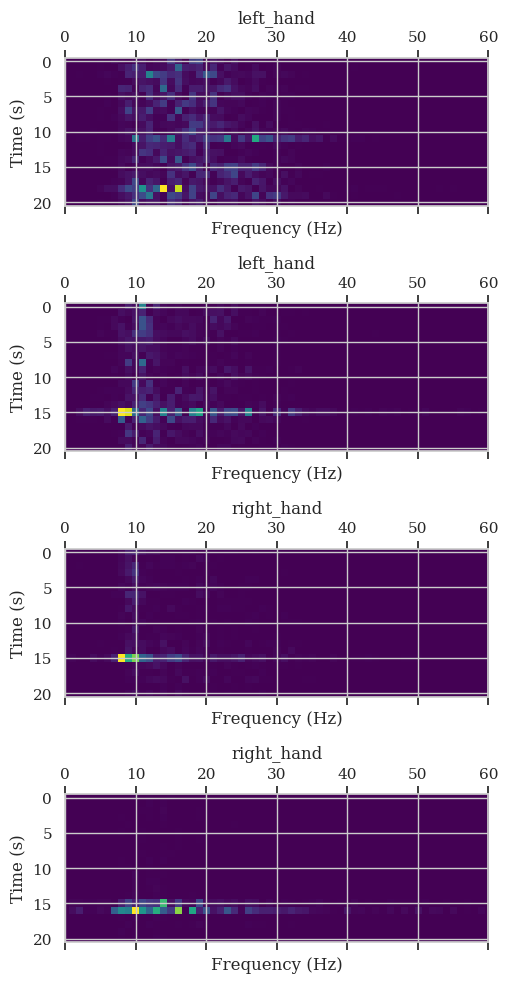

In [253]:
def create_spectrogram(epoch_data):
    spectrograms = []
    for epoch in epoch_data:
        epoch_spectrograms = []
        for channel in epoch:
            f, t, Sxx = sp.signal.spectrogram(channel, fs=50)
            epoch_spectrograms.append(Sxx)
        spectrograms.append(np.array(epoch_spectrograms))
    return np.array(spectrograms)

spectograms = create_spectrogram(X)
rprint(spectograms.shape) # (180, 21, 129, 2)

num_left_hand_epochs_to_visualize = 2
num_right_hand_epochs_to_visualize = 2

# Select epochs for visualization
left_hand_epochs_to_visualize = np.where((y == 'left_hand'))[0]
right_hand_epochs_to_visualize = np.where((y == 'right_hand'))[0]
left_hand_epochs_to_visualize = np.random.choice(left_hand_epochs_to_visualize, num_left_hand_epochs_to_visualize)
right_hand_epochs_to_visualize = np.random.choice(right_hand_epochs_to_visualize, num_right_hand_epochs_to_visualize)
epochs_to_visualize = np.concatenate((left_hand_epochs_to_visualize, right_hand_epochs_to_visualize))

rprint(epochs_to_visualize)

# Visualize spectrograms
fig, axs = plt.subplots(epochs_to_visualize.size, 1, figsize=(10, 10))
for i, idx in enumerate(epochs_to_visualize):
    axs[i].matshow(spectograms[idx, :, :, 0], cmap='viridis')
    axs[i].set_title(y[idx])
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Time (s)')
    axs[i].set_xlim(0, 60) # Limit x-axis to 60Hz

plt.tight_layout()
plt.show()